### packages

In [31]:
import pandas as pd

from shapely.geometry import Point, Polygon

import geopandas as gp

import numpy as np

import random

import pulp

import folium

import networkx as nx

import math

import h3

import os,sys

import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

import copy

import datetime

from scipy.stats import poisson

import scipy.stats as stats

### udf

In [32]:
'''Hexagonal classes'''

class Hexagon(object):
    
    '''
    Functions:
    
    (1) convert geographical coordinates to hexgon
    
    (2) Generate a set of neighbor hexagons for the given hexgon
    
    '''
    
    def __init__(self,resolution):
        
        self.resolution=resolution
        
    def Get_Hex(self,lat,lng):
        
        '''
        Input: latitude,longitude
        
        Output: hexgon
        
        '''
        
        return h3.geo_to_h3(lat,lng,self.resolution)
    
    def Get_Neigh(self,hexgon,radius):
        
        '''
        Input: central hexgon,radius
        
        Output: set of neighbor hexgons
        
        '''
        
        y= h3.hex_range_distances(hexgon, radius)
        
        x=list()
        for y_ in y:
            for y__ in y_:
                x.append(y__)
        return x
    
    def Compact_lists(self,hexagons):
        
        '''
        Input: list of hexgons
        
        Output: set of hexgons
        
        '''
        
        result=list()
    
        for a in hexagons:

            result=list(set(result+a))

        return result
    
    def Center_point(self,hexagon):
        
        return [p for p in h3.h3_to_geo(hexagon)]
    
    def Sample_point(self,hexagon):
        
        '''
        Input: hexgon
        
        Output: point
        
        '''
        
        boundary=h3.h3_to_geo_boundary(hexagon)
        poly = Polygon(boundary)
        (minx, miny, maxx, maxy) = poly.bounds
        while True:
            p = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
            if poly.contains(p):
                return [list(p.coords)[0][0],list(p.coords)[0][1]]
            
'''Week Transfer'''

def get_week_day(date):
    
    date=datetime.datetime.strptime(date, '%Y-%m-%d')
    
    week_day_dict = {
    0 : 'MON',
    1 : 'TUE',
    2 : 'WED',
    3 : 'THU',
    4 : 'FRI',
    5 : 'SAT',
    6 : 'SUN',
    }
    day = date.weekday()
    
    return week_day_dict[day]

'''Stochastic '''

def Truncated_Gauss(mu,sigma,lower,upper):

    X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    
    return round(X.rvs(1)[0],2)


### param

In [33]:
'''Systemic paths'''

Load_path='./Data/NYC_Network/'

Supply_path='./data/supply/'

Figure_path = './figures/'


'''Parameters'''


Start_step=6120 # Start stamp 

End_step=7560 # End stamp 


'''Network data'''

'''Grid-related data'''

Grid_list=np.load(os.path.join(Load_path,'Grids.npy'),allow_pickle=True)

Grid_Point=np.load(os.path.join(Load_path,'Grid_Point.npy'),allow_pickle=True).item()

'''Point-related data'''

Points_list=np.load(os.path.join(Load_path,'Points_list.npy'),allow_pickle=True)

Link_Point=np.load(os.path.join(Load_path,'Link_Point.npy'),allow_pickle=True).item()

Point_coordinate=np.load(os.path.join(Load_path,'Point_coordinate.npy'),allow_pickle=True).item()

Point_Grid=np.load(os.path.join(Load_path,'Point_Grid.npy'),allow_pickle=True).item()


resolution=9


Hex=Hexagon(resolution)

Save_path = './Real_World/'


'''Generation data'''

ini_num=300


# Zone

Center=Point(-73.955575,40.782341)

Lower=Point(-73.991472,40.732128)

def Get_POLYGON(coords):
    
    if coords.type=='Polygon':
        
        return coords
    
    else:
        
        Score={i:coords[i].area for i in range(len(coords))}
        
        idx=max(Score, key=Score.get)
        
        return coords[idx]

    
def Get_distance(point1,point2):
    
    return point1.distance(point2)*111000*1.2


Zone_data = gp.read_file('./Data/NYC_Zones/geo_export_789b911c-2a6d-4092-a682-6c5e6ce53409.shp')

Zone_data=Zone_data.loc[Zone_data['borough']=='Manhattan']

Zone_data=Zone_data.reset_index(drop=True)

Zone_data=Zone_data.reset_index(drop=True)

Zone_data['Zone_id']=['Zone_'+str(i) for i in Zone_data.index]

Zone_data=Zone_data[['Zone_id','borough','zone','geometry']]

Islands=['Zone_19','Zone_20','Zone_21','Zone_38','Zone_47','Zone_48']

Zone_data=Zone_data.loc[~Zone_data['Zone_id'].isin(Islands)]

Zone_data=Zone_data.reset_index(drop=True)

Zone_data['Zone_id']=['Zone_'+str(i) for i in Zone_data.index]

Zone_data['geometry']=Zone_data.apply(lambda x:Get_POLYGON(x['geometry']),axis=1)

Zone_data['center'] = Zone_data.apply(lambda x:x['geometry'].centroid,axis=1)

Zone_data['distance']=Zone_data.apply(lambda x:Get_distance(x['center'],Center),axis=1)

Zone_data['Label']='C'

Zone_data['Label']=Zone_data.apply(lambda x:'B' if x['distance'] <5000 else x['Label'], axis=1)

Zone_data['distance']=Zone_data.apply(lambda x:Get_distance(x['center'],Lower),axis=1)

Zone_data['Label']=Zone_data.apply(lambda x:'A' if x['distance'] <6000 and x['Label'] !='B' else x['Label'], axis=1)

Zone_data

Zone_label={}

Grid_label={}

Grid_Records=[]

for idx,row in Zone_data.iterrows():
    
    zone=row['zone']
    
    label=row['Label']
    
    geometry=row['geometry']
    
    Zone_label[zone]=label
    
    for grid in Grid_list:
        
        center=Point(h3.h3_to_geo(str(grid))[::-1])
        
        if grid not in Grid_Records:
        
            if geometry.contains(center):

                Grid_label[grid]=label

                Grid_Records.append(grid)
                
Grid_label  


# street data

Street_data = gp.read_file('./Data/NYC_Street/geo_export_2d0a9cb9-782e-42c0-ba15-7345a0f64002.shp')

Street_data=Street_data.loc[(Street_data['borocode']=='1')&(Street_data['rw_type'].isin([1,3]))&(Street_data['status']=='2')]

Street_data=Street_data[['st_name','geometry','shape_leng']]

Street_data=Street_data.rename(columns={'shape_leng':'length'})

Street_data['start']=Street_data.apply(lambda x:list(x['geometry'].coords)[0][::-1],axis=1)

Street_data['end']=Street_data.apply(lambda x:list(x['geometry'].coords)[-1][::-1],axis=1)

Street_data['start_grid']=Street_data.apply(lambda x:h3.geo_to_h3(x['start'][0],x['start'][1],resolution),axis=1)

Street_data['end_grid']=Street_data.apply(lambda x:h3.geo_to_h3(x['end'][0],x['end'][1],resolution),axis=1)

Street_data=Street_data.loc[(Street_data['start_grid'].isin(Grid_label.keys()))&(Street_data['end_grid'].isin(Grid_label.keys()))]

Street_data['tag']=Street_data.apply(lambda x:Grid_label[x['start_grid']],axis=1)
                        
Street_data=Street_data.reset_index(drop=True)

Street_data

Points=np.concatenate((Street_data.start.unique(),Street_data.end.unique()), axis=0)

Points=np.unique(Points)

Points

# Grid_Points={}

# for idx,row in Street_data.iterrows():
    
#     if row.start_grid not in Grid_Points>keys():
        
#         Grid_Points[row.start_grid]=[row.start]
        
#     else:
        
#         if row.start not in Grid_Points[row.start_grid].values():
        
#              Grid_Points[row.start_grid].append(row.start)
            
        
    
    
# Grid_Points


<ipython-input-33-71b18294487b>:64: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  Score={i:coords[i].area for i in range(len(coords))}
<ipython-input-33-71b18294487b>:64: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  Score={i:coords[i].area for i in range(len(coords))}
<ipython-input-33-71b18294487b>:68: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return coords[idx]
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:112: ShapelyDeprecationWarning: The array interface is deprecated and will no lon

array([(40.701133021401304, -74.01372314441093),
       (40.70120035637349, -74.01374768342369),
       (40.70122874396886, -74.01431840498627), ...,
       (40.87695391910112, -73.92348737154121),
       (40.87714216663587, -73.92307297834543),
       (40.877188677911754, -73.92312291511975)], dtype=object)

### date range

In [34]:
'''Pick up 10 week days'''

Weekdays=[]

Dates=[str(x)[:10] for x in pd.date_range('12/1/2020','12/14/2020')]

for dt in Dates:
    
    if get_week_day(dt) not in ['SAT','SUN']:
        
        Weekdays.append(dt)
        
    if len(Weekdays)>10:
        
        break
        

### supply data generation

\begin{equation}
u_{d,o}=\overbrace{\beta_{0,d} \cdot I_{o}}^{\textrm{order type}} +\overbrace{\beta_{1,d} \cdot f_{o}}^{\textrm{order fare}} - \overbrace{\beta_{2,d} \cdot \tau(l^{\textrm{org}}_{o},l_{d})}^{\textrm{pickup time}}  + \overbrace{\beta_{3,d} \cdot V(l^{\textrm{dest}}_{o})}^{\textrm{value of the order's destination}}
\label{eq:utility}
\end{equation}


In [35]:
# arrival rate for drivers

Label_grid={}

for grid,label in Grid_label.items():
    
    if label not in Label_grid.keys():
        
        Label_grid[label]=[grid]
        
    else:
        
        Label_grid[label].append(grid)

arrival_num=10

def Generate_grid(Label_grid):
    
    coin=random.random()
    
    if coin<=0.05:
        
        grid=random.choice(Label_grid['C'])
        
        while len(Grid_Point[grid])==0:
            
            grid=random.choice(Label_grid['C'])
    
    elif coin> 0.05 and coin<=0.5:
        
        grid=random.choice(Label_grid['B'])
        
        while len(Grid_Point[grid])==0:
            
            grid=random.choice(Label_grid['B'])
    
    else:
        
        grid=random.choice(Label_grid['A'])
        
        while len(Grid_Point[grid])==0:
            
            grid=random.choice(Label_grid['A'])
            
    return grid
    
 

for dt in Weekdays:
                 
    Driver_num=copy.deepcopy(ini_num)

    Driver_list=['D'+str(i) for i in range(Driver_num)]

    Driver_df=pd.DataFrame(Driver_list,columns=['Driver_id'])
    
    Driver_df['Grid']=Driver_df.apply(lambda x:Generate_grid(Label_grid),axis=1)
    
    Driver_df['Point']=Driver_df.apply(lambda x:Point_coordinate[np.random.choice(Grid_Point[x['Grid']])],axis=1)
    
    Driver_df['Step']=Start_step

    Driver_df['Order_id']='Idle'

    Driver_df=Driver_df[['Driver_id','Order_id','Step','Point','Grid']]
    
    # preference data


    '''Generate Vehicles by minute'''

    Arrival_rate={}

    Minute_step={}

    for step in range(Start_step,Start_step+180,1):
        
        if step%6==0:

            for i in range(np.random.randint(5,10)):

                Added_item={}

                driver_id='D'+str(Driver_num)

                Added_item['Driver_id']=driver_id

                Added_item['Order_id']='Idle'

                Added_item['Step']=step
                
                grid=Generate_grid(Label_grid)
                
                pnt=Point_coordinate[np.random.choice(Grid_Point[grid])]
                
                Added_item['Grid']=grid
    
                Added_item['Point']=pnt

                Driver_df=Driver_df.append(Added_item, ignore_index=True)

                Driver_num+=1
                
    # Collection
    
    Driver_df=Driver_df[['Driver_id','Order_id','Step','Point','Grid']]

    
    Driver_df.to_csv(os.path.join(Supply_path,'Driver_df_'+str(dt)+'.csv'))
    
    print(f'The number of orders in '+str(dt)+' is '+str(Driver_df.shape[0]))

Driver_df

The number of orders in 2020-12-01 is 520
The number of orders in 2020-12-02 is 498
The number of orders in 2020-12-03 is 516
The number of orders in 2020-12-04 is 512
The number of orders in 2020-12-07 is 506
The number of orders in 2020-12-08 is 506
The number of orders in 2020-12-09 is 512
The number of orders in 2020-12-10 is 517
The number of orders in 2020-12-11 is 507
The number of orders in 2020-12-14 is 516


,Driver_id,Order_id,Step,Point,Grid
0,D0,Idle,6120,"(40.710943186682364, -74.01496257948904)",892a10728d7ffff
1,D1,Idle,6120,"(40.727337256858746, -74.00058982676626)",892a1072cc7ffff
2,D2,Idle,6120,"(40.767242953378826, -73.98620388109224)",892a100d65bffff
3,D3,Idle,6120,"(40.71767141656398, -74.01576940707116)",892a1072c6bffff
4,D4,Idle,6120,"(40.81875825333526, -73.95977206728521)",892a1008c13ffff
...,...,...,...,...,...
511,D511,Idle,6294,"(40.77682991368621, -73.98913130662316)",892a1008b0fffff
512,D512,Idle,6294,"(40.771426856464345, -73.94636972293151)",892a100d4dbffff
513,D513,Idle,6294,"(40.71599826551065, -74.0070972885244)",892a1072c67ffff
514,D514,Idle,6294,"(40.749076818493414, -73.98607892437585)",892a100d2d7ffff


In [36]:
Driver_df


,Driver_id,Order_id,Step,Point,Grid
0,D0,Idle,6120,"(40.710943186682364, -74.01496257948904)",892a10728d7ffff
1,D1,Idle,6120,"(40.727337256858746, -74.00058982676626)",892a1072cc7ffff
2,D2,Idle,6120,"(40.767242953378826, -73.98620388109224)",892a100d65bffff
3,D3,Idle,6120,"(40.71767141656398, -74.01576940707116)",892a1072c6bffff
4,D4,Idle,6120,"(40.81875825333526, -73.95977206728521)",892a1008c13ffff
...,...,...,...,...,...
511,D511,Idle,6294,"(40.77682991368621, -73.98913130662316)",892a1008b0fffff
512,D512,Idle,6294,"(40.771426856464345, -73.94636972293151)",892a100d4dbffff
513,D513,Idle,6294,"(40.71599826551065, -74.0070972885244)",892a1072c67ffff
514,D514,Idle,6294,"(40.749076818493414, -73.98607892437585)",892a100d2d7ffff


### minutely distribution

<ipython-input-37-d04a07086bb6>:81: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax1.set_xticklabels(['','05:00', '05:10','05:20','05:30','05:40','05:50',\
<ipython-input-37-d04a07086bb6>:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['','05:00', '05:10','05:20','05:30','05:40','05:50',\


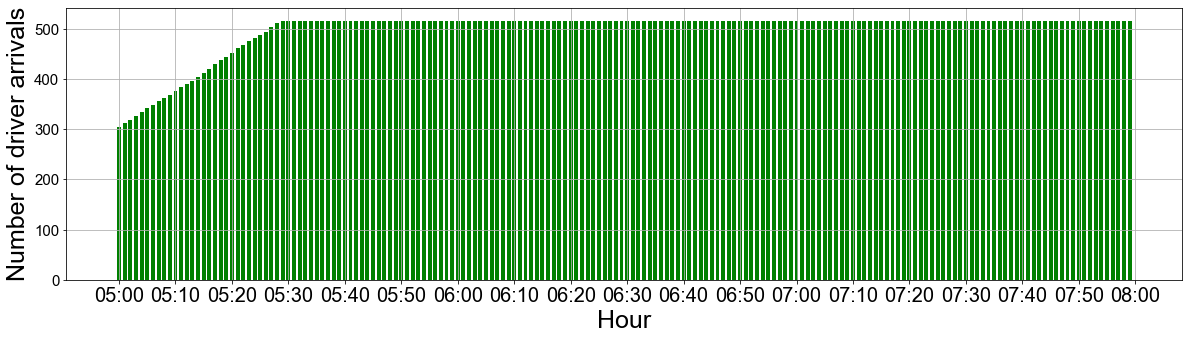

In [37]:
def minute_stat(df):
    
    df['minute']=df.apply(lambda x:int((x['Step']-Start_step)/6.0),axis=1)
    
    stat_df=df.groupby(['minute']).count()

    stat_df['minute']=stat_df.index
    
    stat_df=stat_df.reset_index(drop=True)
    
    return stat_df[['minute','Driver_id']]

driver_df=pd.read_csv(os.path.join(Supply_path,'Driver_df_'+str(dt)+'.csv'))

stat_df=minute_stat(driver_df)

driver_num={}

for i in range(180):
    
    if i in stat_df.minute.to_list():
    
        if i==0:

            driver_num[i]=int(stat_df.loc[stat_df.minute==i,'Driver_id'])

        else:

            driver_num[i]=driver_num[i-1]+int(stat_df.loc[stat_df.minute==i,'Driver_id'])
            
    else:
        
        driver_num[i]=driver_num[i-1]
        


'''Plot Figure'''

figsize = 20,5

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 25}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

figure, ax1 = plt.subplots(figsize=figsize)

labels = ax1.get_xticklabels() + ax1.get_yticklabels()

[label.set_fontsize(15) for label in labels]

[label.set_fontname('Arial') for label in labels]

'''Plot'''

cumulative=[0  for i in list(driver_num.keys())]

ax1.bar(list(driver_num.keys()),\
        list(driver_num.values()),\
        bottom=cumulative,
        width = 0.7,\
        facecolor = 'green')


ax1.set_ylabel('Number of driver arrivals',font_label)

ax1.set_xlabel('Hour',font_label)


xmajorLocator   = MultipleLocator(10)

ax1.xaxis.set_major_locator(xmajorLocator) 


# ax1.set_xlim([-5,180])


# ax1.set_ylim([0,175])

ax1.set_xticklabels(['','05:00', '05:10','05:20','05:30','05:40','05:50',\
                        '06:00', '06:10','06:20','06:30','06:40','06:50',\
                        '07:00', '07:10','07:20','07:30','07:40','07:50',\
                        '08:00', '08:10','08:20','08:30','08:40','08:50','09:00'],font_legend)
plt.grid()

current_fig = plt.gcf() # 'get current figure'

current_fig.savefig(os.path.join(Figure_path,'Supply_Arrivals.eps'), format='eps', dpi=1000, bbox_inches = 'tight')

plt.show()